<a href="https://colab.research.google.com/github/mzignis/hands_on_machine_learning/blob/master/artificial_neural_networks/mnist_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from hyperopt import hp, STATUS_OK, tpe, Trials, fmin

sns.set()

In [0]:
mnist = fetch_openml('mnist_784', version=1)

In [0]:
X = mnist.data
y = mnist.target.astype(np.int)

In [0]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full)

In [5]:
input_shape = X_train.shape[1]
X_train.shape, y_train.shape

((39375, 784), (39375,))

In [0]:
def create_model(params: dict):
    model = keras.models.Sequential()

    # -------- input layer --------
    model.add(keras.Input(shape=X_train.shape[1:]))

    # -------- deep layers --------
    layers_number = int(params.get('deep_layers_no', 1))
    neurons_number = int(params.get('neurons_number', 100))

    for layer_no in range(layers_number):
        model.add(keras.layers.Dense(neurons_number, activation='relu'))

    # -------- output layer --------
    model.add(keras.layers.Dense(10, activation='softmax'))

    learning_rate = params.get('learning_rate', 1e-3)
    optimizer = params.get('optimizer', 'Adam')
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=optimizer, 
                  metrics=["accuracy"])
    
    return model

In [0]:
def fit_model(model, X_train, y_train, params: dict):
    history = model.fit(X_train, y_train, 
                        batch_size=int(params.get('batch_size', 32)),
                        epochs=int(params.get('epochs', 5)),
                        verbose=params.get('verbose', 0),
                        validation_data=params.get('validation_data', (X_val, y_val)),
                        callbacks=params.get('callbacks', []))
    return history

In [0]:
def fit_and_evaluate(params: dict = None):

    model_params = params.get('model_params', {})
    fit_params = params.get('fit_params', {})

    model = create_model(model_params)
    # model.summary()

    history = fit_model(model, X_train, y_train, fit_params)

    score = model.evaluate(X_test, y_test, verbose=0)
    accuracy = score[1]

    print(f'params={params}')
    print(f'accuracy={accuracy}')

    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

In [9]:
model_dict = fit_and_evaluate(params={'model_params': {'deep_layers_no': 3, 
                                                        'neurons_number': 150,
                                                        'optimizer': 'Adam',
                                                        'learning_rate': 3e-4}, 
                                      'fit_params': {'batch_size': 32, 
                                                     'epochs': 1,
                                                     'callbacks': [keras.callbacks.EarlyStopping(patience=10)]
                                                     }
                                      }
                              )


# pd.DataFrame(history.history).plot(figsize=(8, 5))
# plt.grid(True)
# plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
# plt.show()

params={'model_params': {'deep_layers_no': 3, 'neurons_number': 150, 'optimizer': 'Adam', 'learning_rate': 0.0003}, 'fit_params': {'batch_size': 32, 'epochs': 1, 'callbacks': [<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7fca1baa6cf8>]}}
accuracy=0.9137142896652222


In [0]:
space = {
    'model_params': {
        'deep_layers_no': hp.quniform('deep_layers_no', 1, 3, 1),
        'neurons_number': hp.quniform('neurons_number', 100, 500, 25),
        'learning_rate': hp.uniform('learning_rate', 1e-2, 1e-5)
    },
    'fit_params': {
        'batch_size': hp.quniform('batch_size', 20, 128, 1),
        'epochs': hp.quniform('epochs', 5, 100, 5),
        'callbacks': [keras.callbacks.EarlyStopping(patience=20)]
    }
}

In [17]:
best = fmin(
    fn=fit_and_evaluate,
    space=space,
    algo=tpe.suggest,
    max_evals=15,
    verbose=False,
    trials=Trials(),
)

params={'fit_params': {'batch_size': 71.0, 'callbacks': (<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7fca007ac7f0>,), 'epochs': 20.0}, 'model_params': {'deep_layers_no': 1.0, 'learning_rate': 0.0008624620024764423, 'neurons_number': 425.0}}
accuracy=0.9590857028961182
params={'fit_params': {'batch_size': 125.0, 'callbacks': (<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7fca007ac7f0>,), 'epochs': 45.0}, 'model_params': {'deep_layers_no': 1.0, 'learning_rate': 0.0024896662166385385, 'neurons_number': 250.0}}
accuracy=0.9678857326507568
params={'fit_params': {'batch_size': 61.0, 'callbacks': (<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7fca007ac7f0>,), 'epochs': 30.0}, 'model_params': {'deep_layers_no': 3.0, 'learning_rate': 0.009417083220363703, 'neurons_number': 250.0}}
accuracy=0.969257116317749
params={'fit_params': {'batch_size': 63.0, 'callbacks': (<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7fca007ac7f0>,), 'epochs'

In [18]:
best

{'batch_size': 57.0,
 'deep_layers_no': 3.0,
 'epochs': 40.0,
 'learning_rate': 0.004655646015724878,
 'neurons_number': 175.0}

In [0]:
best_params = {
    'model_params': {
        'deep_layers_no': 3,
        'neurons_number': 175,
        'learning_rate': 0.004655646015724878
    },
    'fit_params': {
        'batch_size': 32,
        'epochs': 40,
        'callbacks': [keras.callbacks.EarlyStopping(patience=20)]
    }
}

In [20]:
model_dict = fit_and_evaluate(best_params)
model_dict

params={'model_params': {'deep_layers_no': 3, 'neurons_number': 175, 'learning_rate': 0.004655646015724878}, 'fit_params': {'batch_size': 32, 'epochs': 40, 'callbacks': [<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7fca006e1ac8>]}}
accuracy=0.9733142852783203


{'loss': -0.9733142852783203,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fca007acfd0>,
 'status': 'ok'}

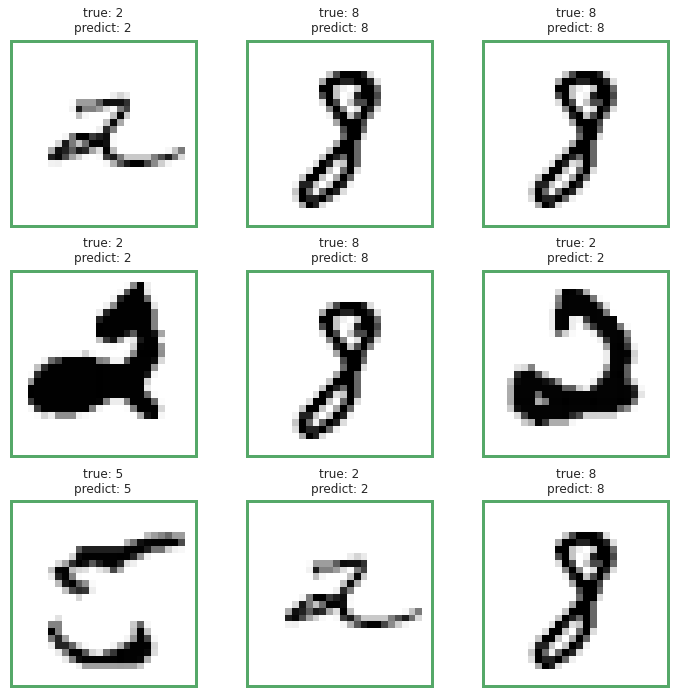

In [59]:
model = model_dict['model']

rnd_idx = np.random.randint(10, size=9).tolist()

X_new = X_test[rnd_idx]
y_new = y_test[rnd_idx]

y_pred = model.predict_classes(X_new)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

idx = -1
for row in axes:
    for ax in row:
        idx += 1
        ax.imshow(X_new[idx].reshape(28, 28), cmap='Greys')
        ax.set_title(f'true: {y_new[idx]}\npredict: {y_pred[idx]}')
        color = 'g' if y_pred[idx] == y_new[idx] else 'r'
        rect = patches.Rectangle((0, 0), 27, 27, linewidth=3, edgecolor=color, facecolor='none')
        
        ax.add_patch(rect)
        ax.set_axis_off()